Pronóstico de muertes del Titanic usando estimadores
===

* *30 min* | Última modificación: Agosto 6, 2021 | YouTube

Basado en https://www.tensorflow.org/tutorials/estimator/linear

En esta lección se construye un estimador lineal para pronosticar los sobrevivientes del Titanic.

## Importación de librerías

In [1]:
import warnings

warnings.filterwarnings("ignore")

# import os
# import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print(tf.__version__)

#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.5.0


## Semilla del generador de números aleatorios

In [2]:
tf.random.set_seed(123)

## Carga y configuración del dataset

In [3]:
#
#  Carga del dataset
#
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")

y_train = dftrain.pop("survived")
y_eval = dfeval.pop("survived")

#
#  Verificación.
#
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


## Exploración del dataset

In [4]:
#
#  Estadísticos de las columnas numéricas
#
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
#
#  Cantidad de registros de los datasets
#
dftrain.shape[0], dfeval.shape[0]

(627, 264)

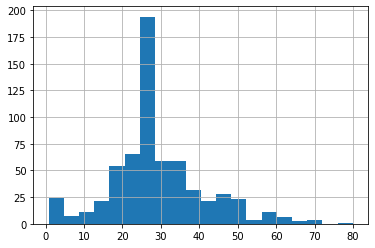

In [6]:
#
#  Histograma de la edad
#
dftrain.age.hist(bins=20)

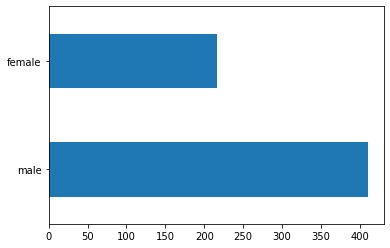

In [7]:
#
#  Distribución de los pasajeros por sexo
#
dftrain.sex.value_counts().plot(kind="barh")

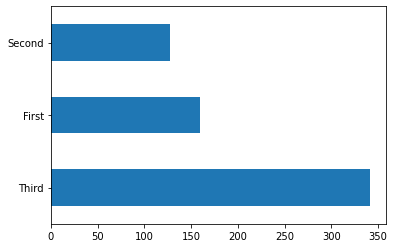

In [8]:
#
#  Distribución de los pasajeros por clase
#
dftrain["class"].value_counts().plot(kind="barh")

Text(0.5, 0, '% survive')

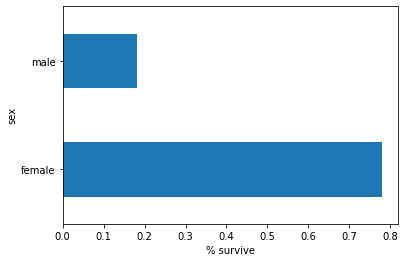

In [9]:
#
#  Distribución de los pasajeros sobrevivientes
#  por sexo
#
pd.concat([dftrain, y_train], axis=1).groupby("sex").survived.mean().plot(
    kind="barh"
).set_xlabel("% survive")

## Preparación de los datos para usar el estimador

In [10]:
CATEGORICAL_COLUMNS = [
    "sex",
    "n_siblings_spouses",
    "parch",
    "class",
    "deck",
    "embark_town",
    "alone",
]
NUMERIC_COLUMNS = ["age", "fare"]


#
#  Se genera una lista que tiene el tipo de cada columna
#
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    
    vocabulary = dftrain[feature_name].unique()
    
    feature_columns.append(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, 
            vocabulary,
        )
    )

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(
            feature_name, 
            dtype=tf.float32,
        )
    )

In [11]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        "class", ("First", "Second", "Third")
    )
)
print('Feature value: "{}"'.format(example["class"].iloc[0]))
print("One-hot encoded: ", tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [12]:
NUM_EXAMPLES = len(y_train)


def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    
    def input_function():
        
        ds = tf.data.Dataset.from_tensor_slices(
            (dict(data_df), label_df)
        )
        
        if shuffle:
            ds = ds.shuffle(NUM_EXAMPLES)
            
        ds = ds.batch(batch_size).repeat(num_epochs)
        
        return ds

    return input_function


train_input_fn = make_input_fn(
    dftrain, 
    y_train,
)

eval_input_fn = make_input_fn(
    dfeval, 
    y_eval, 
    num_epochs=1, 
    shuffle=False,
)

In [13]:
#
#  Ejemplo de las salidas de la función make_input_fn.
#  Note que una sola llamada genera un batch para el entrenamiento
#
ds = make_input_fn(dftrain, y_train, batch_size=10)()

for feature_batch, label_batch in ds.take(1):
    print("Some feature keys:", list(feature_batch.keys()))
    print()
    print("A batch of class:", feature_batch["class"].numpy())
    print()
    print("A batch of Labels:", label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'Third' b'Third' b'First' b'Third' b'Second' b'Third'
 b'Second' b'Second']

A batch of Labels: [1 1 0 0 1 0 0 1 0 0]


In [14]:
#
#  Batch para la columna edad.
#
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures(
    [age_column]
)(feature_batch).numpy()

array([[31. ],
       [58. ],
       [32. ],
       [14. ],
       [31. ],
       [21. ],
       [59. ],
       [16. ],
       [32.5],
       [28. ]], dtype=float32)

In [15]:
#
#  Batch para la columna gender
#
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures(
    [tf.feature_column.indicator_column(gender_column)]
)(
    feature_batch
).numpy()

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Creación,entrenamiento y evaluación de los modelos

In [16]:
#
# Clasificador lineal 
#
linear_est = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
)

linear_est.train(train_input_fn)

pd.Series(linear_est.evaluate(eval_input_fn))

accuracy                  0.768939
accuracy_baseline         0.625000
auc                       0.825620
auc_precision_recall      0.779603
average_loss              0.505273
label/mean                0.375000
loss                      0.495973
precision                 0.731707
prediction/mean           0.309599
recall                    0.606061
global_step             200.000000
dtype: float64

In [17]:
#
# Boosted Tree
#
tree_est = tf.estimator.BoostedTreesClassifier(
    feature_columns=feature_columns, 
    n_batches_per_layer=1
)

tree_est.train(
    train_input_fn, 
    max_steps=100,
)

pd.Series(tree_est.evaluate(eval_input_fn))

Exception ignored in: <bound method CapturableResource.__del__ of <tensorflow.python.ops.boosted_trees_ops.TreeEnsemble object at 0x7ff20409ebe0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py", line 269, in __del__
    with self._destruction_context():
AttributeError: 'TreeEnsemble' object has no attribute '_destruction_context'
Exception ignored in: <bound method CapturableResource.__del__ of <tensorflow.python.ops.boosted_trees_ops.TreeEnsemble object at 0x7ff1d06d43c8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py", line 269, in __del__
    with self._destruction_context():
AttributeError: 'TreeEnsemble' object has no attribute '_destruction_context'


accuracy                5.871212e-01
accuracy_baseline       6.250000e-01
auc                     6.275175e-01
auc_precision_recall    6.706861e-01
average_loss            3.392165e+09
label/mean              3.750000e-01
loss                    3.109485e+09
precision               4.709302e-01
prediction/mean         6.520945e-01
recall                  8.181818e-01
global_step             1.000000e+02
dtype: float64

## Exploración de características derivadas

In [18]:
#
#  Combinación de características
#
age_x_gender = tf.feature_column.crossed_column(
    ["age", "sex"], 
    hash_bucket_size=100,
)

#
#  Entrenamiento
#
derived_feature_columns = [age_x_gender]

linear_est = tf.estimator.LinearClassifier(
    feature_columns=feature_columns + derived_feature_columns
)

linear_est.train(train_input_fn)

#
#  Resultados
#
pd.Series(linear_est.evaluate(eval_input_fn))

accuracy                  0.772727
accuracy_baseline         0.625000
auc                       0.849923
auc_precision_recall      0.788106
average_loss              0.468580
label/mean                0.375000
loss                      0.459226
precision                 0.729412
prediction/mean           0.340925
recall                    0.626263
global_step             200.000000
dtype: float64

## Pronóstico

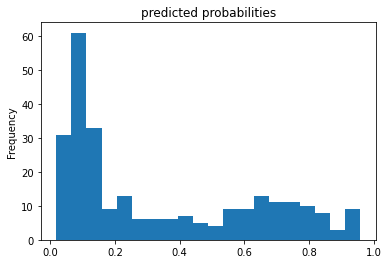

In [19]:
pred_dicts = list(
    linear_est.predict(eval_input_fn)
)

probs = pd.Series(
    [pred["probabilities"][1] for pred in pred_dicts]
)

probs.plot(
    kind="hist", 
    bins=20, 
    title="predicted probabilities",
)

## Curva ROC

(0.0, 1.05)

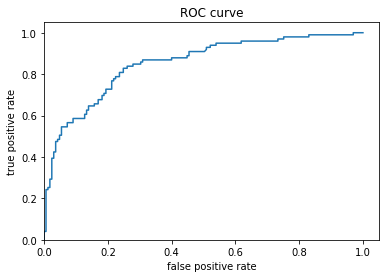

In [20]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.xlim(0,)
plt.ylim(0,)